In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/data/')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Anet(nn.Module):
    def __init__(self, chns=1):
        super(Anet, self).__init__()
        self.chns = chns
        self.conv1 = nn.Conv2d(1, self.chns, kernel_size=(33,1), padding=(16,0), padding_mode='replicate', bias=False, groups=1) 
       
        self.conv2 = nn.Conv2d(self.chns, 1, kernel_size=(1,33), padding=(0,16), padding_mode='replicate', bias=False, groups=1) 

    def forward(self, x):
        x1 =self.conv1(x)
        x2 = F.relu(self.conv2(x1))
        #x2 = self.conv2(x1)

        U = model.conv1.weight.detach().clone() # first conv kernel
        V = model.conv2.weight.detach().clone() # second conv kernel
        return x2,x1,U,V
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device
model = Anet().to(device)
print(model)

Anet(
  (conv1): Conv2d(1, 1, kernel_size=(33, 1), stride=(1, 1), padding=(16, 0), bias=False, padding_mode=replicate)
  (conv2): Conv2d(1, 1, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16), bias=False, padding_mode=replicate)
)


In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [3]:
from PIL import Image
from torchvision import transforms

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
from io import BytesIO


class Gauss_func(object):
    
    def __init__(self, k=33):
        r = k // 2
        k = r * 2 + 1
        self.gauss_u = nn.Conv2d(1, 1, kernel_size=(k, 1), padding=(16,0), padding_mode='replicate'
                                , bias=False, groups=1)
        self.gauss_v = nn.Conv2d(1, 1, kernel_size=(1, k),padding=(0,16), padding_mode='replicate'
                               , bias=False, groups=1)
        self.k = k 
        self.r = r

        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = torch.tensor(np.asarray(img)).unsqueeze(0).float()
        img=img.unsqueeze(0).float() 
        img = img.permute(0, 1, 2, 3)

        sigma = 2
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(1, 1) 

        self.gauss_u.weight.data.copy_(x.view(1, 1, self.k, 1))
        self.gauss_v.weight.data.copy_(x.view(1, 1, 1, self.k))

        with torch.no_grad():
            img = self.gauss_u(img)
            img = self.gauss_v(img)
            img = img.squeeze()

        return img


In [4]:
## sub images generation along with the blurred labels
### This block of codes is given from https://github.com/HwangToeMat/SRCNN_Pytorch_HTM, ##### except the Gaussian blur function!!!!!!
import os
import glob
import h5py
import cv2
from PIL import Image
import numpy as np

def mod_crop(image, scale = 3):
    if len(image.shape) ==3:
        h = image.shape[0]
        w = image.shape[1]
        h = h - np.mod(h,scale)
        w = w - np.mod(w,scale)
        return image[0:h,0:w,:]
    else:
        h = image.shape[0]
        w = image.shape[1]
        h = h - np.mod(h,scale)
        w = w - np.mod(w,scale)
        return image[0:h,0:w]

def sub_img(input, label, i_size = 33, l_size = 33, stride = 14):
    sub_ipt = []
    sub_lab = []
    pad = abs(i_size-l_size)//2
    for h in range(0, input.shape[0] - i_size + 1, stride):
        for w in range(0, input.shape[1] - i_size + 1, stride):
            sub_i = input[h:h+i_size,w:w+i_size]
            sub_l = label[h + pad :h + pad + l_size,w + pad :w + pad + l_size]
            sub_i = sub_i.reshape(1, i_size,i_size)
            sub_l = sub_l.reshape(1, l_size,l_size)
            sub_ipt.append(sub_i)
            sub_lab.append(sub_l)
    return sub_ipt, sub_lab

def load_img(file_path):
    dir_path = os.path.join(os.getcwd(), file_path)
    img_path = glob.glob(os.path.join(dir_path, '*.bmp'))
    return img_path

def read_img(img_path):
    # read image
    image = cv2.imread(img_path)
    # rgb > ycbcr
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    image = image[:, :, 0]
    return image

def GB_img(img, scale): #### zoom_img
    label = img.astype('float') / 255
    input= Gauss_func()(label)
    input=input.numpy()
    return input, label

def img_rotate(img, degree):
    height, width = img.shape
    matrix = cv2.getRotationMatrix2D((width/2, height/2), 90*degree, 1)
    if degree == 1 or degree == 3:
        dst = cv2.warpAffine(img, matrix, (height, width))
    else:
        dst = cv2.warpAffine(img, matrix, (width, height))
    return dst

def save_h5(sub_ip, sub_la, savepath = '/content/drive/My Drive/data/imgs_patch.h5'): 
    path = os.path.join(os.getcwd(), savepath)
    with h5py.File(path, 'w') as hf:
        hf.create_dataset('input', data=sub_ip)
        hf.create_dataset('label', data=sub_la)

def data_aug(file_path = '/content/drive/My Drive/data/Train', savepath = '/content/drive/My Drive/data/imgs_patch.h5', i_size = 33, l_size = 33, stride = 14):
    sub_ip = []
    sub_la = []
    num = 1
    img_path = load_img(file_path)
    for _ in img_path:
        image = read_img(_)
        for degree in [0.,1.,2.]:
            image_r = img_rotate(image, degree)
            for scale in [2,3]:
                md_image = mod_crop(image_r, scale)
                input, label = GB_img(md_image, scale)
                sub_ipt, sub_lab = sub_img(input, label, i_size, l_size, stride)
                sub_ip += sub_ipt
                sub_la += sub_lab
        print('data no.',num)
        num += 1
    sub_ip = np.asarray(sub_ip)
    sub_la = np.asarray(sub_la)
    print('input shape : ',sub_ip.shape)
    print('label shape : ',sub_la.shape)
    save_h5(sub_ip, sub_la, savepath)
    print('---------save---------')

if __name__ == '__main__':
    print('starting data augmentation...')
    data_aug()

starting data augmentation...
data no. 1
data no. 2
data no. 3
data no. 4
data no. 5
data no. 6
data no. 7
data no. 8
data no. 9
data no. 10
data no. 11
data no. 12
data no. 13
data no. 14
data no. 15
data no. 16
data no. 17
data no. 18
data no. 19
data no. 20
data no. 21
data no. 22
data no. 23
data no. 24
data no. 25
data no. 26
data no. 27
data no. 28
data no. 29
data no. 30
data no. 31
data no. 32
data no. 33
data no. 34
data no. 35
data no. 36
data no. 37
data no. 38
data no. 39
data no. 40
data no. 41
data no. 42
data no. 43
data no. 44
data no. 45
data no. 46
data no. 47
data no. 48
data no. 49
data no. 50
data no. 51
data no. 52
data no. 53
data no. 54
data no. 55
data no. 56
data no. 57
data no. 58
data no. 59
data no. 60
data no. 61
data no. 62
data no. 63
data no. 64
data no. 65
data no. 66
data no. 67
data no. 68
data no. 69
data no. 70
data no. 71
data no. 72
data no. 73
data no. 74
data no. 75
data no. 76
data no. 77
data no. 78
data no. 79
data no. 80
data no. 81
data no

In [6]:
def data_patch_example(file_path = '/content/drive/My Drive/data/Train', 
i_size = 66, l_size = 66, stride = 14):
    sub_ip = []
    sub_la = []
    num = 1
    img_path = load_img(file_path)
    for _ in img_path:
        if num>1:
          continue
        image = read_img(_)
        for degree in [0.]: #,1.,2.,3.]:
            image_r = img_rotate(image, degree)
            for scale in [2]: #,3,4]:
                md_image = mod_crop(image_r, scale)
                input, label = GB_img(md_image, scale)
                sub_ipt, sub_lab = sub_img(input, label, i_size, l_size, stride)
                sub_ip.append(sub_ipt)
                sub_la.append(sub_lab)
        print('data no.',num)
        num += 1
    sub_ip = np.asarray(sub_ip)
    sub_la = np.asarray(sub_la)
    return sub_ip, sub_la

a,b= data_patch_example(file_path = '/content/drive/My Drive/data/Train')

data no. 1


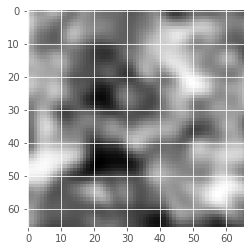

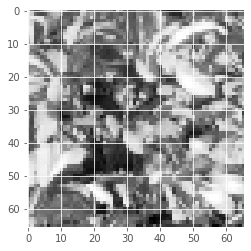

In [9]:
b.shape #### sub image and labal

plt.imshow(a[0,0,0],cmap="gray")
plt.show()
plt.imshow(b[0,0,0],cmap="gray")
plt.show()

In [10]:
sub_imgs = h5py.File('/content/drive/My Drive/data/imgs_patch.h5')
blurred = sub_imgs['input'][:] 
clear = sub_imgs['label'][:] 
sub_imgs.close()
clear = clear.astype('float32')
blurred = blurred.astype('float32')

In [11]:
(clear_train, clear_val, blurr_train, blurr_val) = train_test_split(clear, blurred, test_size=0.25)

In [12]:
clear_train.shape

(98536, 1, 33, 33)

In [13]:

class AnetDataset(Dataset):
    def __init__(self, imgs, labls):
        self.imgs = imgs
        self.labls = labls
    def __len__(self):
        return (len(self.imgs))
    def __getitem__(self, index):
        img = self.imgs[index]
        labl = self.labls[index]
        return (
            torch.tensor(img, dtype=torch.float),
            torch.tensor(labl, dtype=torch.float)
        )

In [15]:
# hyperparamters
batch_num = 64 
epochs = 90
lr = 0.001 

In [16]:
# load train and validation data
imgs_train = AnetDataset(clear_train, blurr_train)
img_valid = AnetDataset(clear_val, blurr_val)
load_train = DataLoader(imgs_train, batch_size=batch_num)
load_valid = DataLoader(img_valid, batch_size=batch_num)

In [17]:
import math

In [18]:
# loss function 
obj=nn.MSELoss()

In [ ]:

def user_loss(recon_y, y, U, V, alpha=0.0001):

    E = torch.subtract(y, recon_y)
    sumE2 = torch.mean(torch.mul(E, E))
    sumU2 = torch.mean(torch.mul(U, U))
    sumV2 = torch.mean(torch.mul(V, V))

    obj = sumE2 + alpha*(sumU2 + sumV2) 

    return obj

In [19]:
optimizer = optim.Adam(model.parameters(), lr=lr)

In [20]:
def recon(model, dataloader):
    model.train()
    batch_loss = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=int(len(imgs_train)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        optimizer.zero_grad()
        x2,_, U, V  = model(image_data)
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) 
        loss = obj(x2, label)
        loss= loss +  0.001*l2_norm 
        
        loss.backward()
        
        optimizer.step()
        
        batch_loss += loss.item()

    loss = batch_loss/len(dataloader.dataset)
    
    return loss

In [21]:
def validate(model, dataloader, epoch):
    model.eval()
    batch_loss = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(img_valid)/dataloader.batch_size)):
            imgs = data[0].to(device)
            labls = data[1].to(device)
            x2,_, U, V  = model(imgs)
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = obj(x2, labls)
            loss= loss +  0.001*l2_norm
            batch_loss += loss.item()
        outputs = x2.cpu()
        #save_image(outputs, f"/content/drive/My Drive/outs/val{epoch}.png")
        
    loss = batch_loss/len(dataloader.dataset)
    
    return loss

In [22]:
Loss_recon, Loss_valid = [], []

start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    loss_recon= recon(model, load_train)
    loss_validate = validate(model, load_valid, epoch)
    Loss_recon.append(loss_recon)

    Loss_valid.append(loss_validate)

end = time.time()
print(f"timing: {((end-start)/60):.3f} mins")

Epoch 1 of 90


1540it [00:12, 120.63it/s]                          
514it [00:00, 518.17it/s]                         


Epoch 2 of 90


1540it [00:05, 272.07it/s]                          
514it [00:01, 347.80it/s]                         


Epoch 3 of 90


1540it [00:05, 278.12it/s]                          
514it [00:01, 500.53it/s]                         


Epoch 4 of 90


1540it [00:05, 269.19it/s]                          
514it [00:01, 353.54it/s]                         


Epoch 5 of 90


1540it [00:05, 288.08it/s]                          
514it [00:01, 504.24it/s]                         


Epoch 6 of 90


1540it [00:05, 263.86it/s]                          
514it [00:01, 353.11it/s]                         


Epoch 7 of 90


1540it [00:05, 286.20it/s]                          
514it [00:01, 508.26it/s]                         


Epoch 8 of 90


1540it [00:05, 257.45it/s]                          
514it [00:01, 414.78it/s]                         


Epoch 9 of 90


1540it [00:05, 285.05it/s]                          
514it [00:01, 503.94it/s]                         


Epoch 10 of 90


1540it [00:06, 250.72it/s]                          
514it [00:01, 437.87it/s]                         


Epoch 11 of 90


1540it [00:05, 288.06it/s]                          
514it [00:01, 506.75it/s]                         


Epoch 12 of 90


1540it [00:06, 240.97it/s]                          
514it [00:01, 491.52it/s]                         


Epoch 13 of 90


1540it [00:05, 288.17it/s]                          
514it [00:01, 498.35it/s]                         


Epoch 14 of 90


1540it [00:06, 253.71it/s]                          
514it [00:01, 504.85it/s]                         


Epoch 15 of 90


1540it [00:05, 286.89it/s]
514it [00:01, 384.39it/s]                         


Epoch 16 of 90


1540it [00:06, 241.14it/s]                          
514it [00:01, 494.50it/s]                         


Epoch 17 of 90


1540it [00:05, 289.67it/s]                          
514it [00:01, 489.53it/s]                         


Epoch 18 of 90


1540it [00:06, 252.18it/s]                          
514it [00:01, 508.23it/s]                         


Epoch 19 of 90


1540it [00:05, 284.25it/s]                          
514it [00:01, 482.72it/s]                         


Epoch 20 of 90


1540it [00:06, 255.12it/s]                          
514it [00:01, 510.38it/s]                         


Epoch 21 of 90


1540it [00:05, 287.95it/s]                          
514it [00:01, 485.32it/s]                         


Epoch 22 of 90


1540it [00:06, 253.11it/s]                          
514it [00:01, 508.67it/s]                         


Epoch 23 of 90


1540it [00:05, 288.34it/s]                          
514it [00:01, 474.09it/s]                         


Epoch 24 of 90


1540it [00:06, 253.68it/s]                          
514it [00:01, 504.70it/s]                         


Epoch 25 of 90


1540it [00:05, 290.32it/s]                          
514it [00:01, 491.97it/s]                         


Epoch 26 of 90


1540it [00:06, 251.53it/s]                          
514it [00:01, 500.03it/s]                         


Epoch 27 of 90


1540it [00:05, 285.60it/s]                          
514it [00:01, 500.34it/s]                         


Epoch 28 of 90


1540it [00:06, 253.48it/s]                          
514it [00:01, 510.13it/s]                         


Epoch 29 of 90


1540it [00:05, 288.56it/s]                          
514it [00:01, 500.06it/s]                         


Epoch 30 of 90


1540it [00:06, 254.11it/s]                          
514it [00:00, 514.81it/s]                         


Epoch 31 of 90


1540it [00:05, 291.78it/s]                          
514it [00:01, 495.00it/s]


Epoch 32 of 90


1540it [00:06, 251.74it/s]                          
514it [00:01, 484.19it/s]                         


Epoch 33 of 90


1540it [00:05, 287.09it/s]                          
514it [00:01, 508.64it/s]                         


Epoch 34 of 90


1540it [00:06, 252.96it/s]                          
514it [00:01, 513.18it/s]                         


Epoch 35 of 90


1540it [00:05, 285.57it/s]                          
514it [00:01, 489.07it/s]                         


Epoch 36 of 90


1540it [00:06, 252.84it/s]                          
514it [00:01, 509.33it/s]                         


Epoch 37 of 90


1540it [00:05, 282.71it/s]                          
514it [00:01, 447.26it/s]                         


Epoch 38 of 90


1540it [00:06, 254.82it/s]                          
514it [00:01, 491.50it/s]                         


Epoch 39 of 90


1540it [00:05, 283.68it/s]                          
514it [00:01, 394.38it/s]                         


Epoch 40 of 90


1540it [00:05, 264.59it/s]                          
514it [00:01, 508.33it/s]                         


Epoch 41 of 90


1540it [00:05, 288.26it/s]                          
514it [00:01, 354.06it/s]                         


Epoch 42 of 90


1540it [00:05, 262.37it/s]                          
514it [00:01, 507.40it/s]                         


Epoch 43 of 90


1540it [00:05, 289.33it/s]                          
514it [00:01, 353.14it/s]                         


Epoch 44 of 90


1540it [00:05, 266.87it/s]                          
514it [00:01, 495.19it/s]                         


Epoch 45 of 90


1540it [00:05, 285.65it/s]                          
514it [00:01, 357.62it/s]


Epoch 46 of 90


1540it [00:05, 268.41it/s]                          
514it [00:01, 506.95it/s]                         


Epoch 47 of 90


1540it [00:05, 278.34it/s]                          
514it [00:01, 353.19it/s]                         


Epoch 48 of 90


1540it [00:05, 276.96it/s]                          
514it [00:01, 510.19it/s]                         


Epoch 49 of 90


1540it [00:05, 283.64it/s]                          
514it [00:01, 350.84it/s]                         


Epoch 50 of 90


1540it [00:05, 272.72it/s]                          
514it [00:01, 497.41it/s]                         


Epoch 51 of 90


1540it [00:05, 273.84it/s]                          
514it [00:01, 352.13it/s]                         


Epoch 52 of 90


1540it [00:05, 278.75it/s]                          
514it [00:01, 496.85it/s]                         


Epoch 53 of 90


1540it [00:05, 275.37it/s]                          
514it [00:01, 357.65it/s]                         


Epoch 54 of 90


1540it [00:05, 283.82it/s]                          
514it [00:01, 500.75it/s]                         


Epoch 55 of 90


1540it [00:05, 268.80it/s]                          
514it [00:01, 362.02it/s]                         


Epoch 56 of 90


1540it [00:05, 285.35it/s]                          
514it [00:01, 509.40it/s]                         


Epoch 57 of 90


1540it [00:05, 269.18it/s]                          
514it [00:01, 351.89it/s]                         


Epoch 58 of 90


1540it [00:05, 290.59it/s]                          
514it [00:01, 512.43it/s]                         


Epoch 59 of 90


1540it [00:05, 266.71it/s]                          
514it [00:01, 349.78it/s]                         


Epoch 60 of 90


1540it [00:05, 282.87it/s]                          
514it [00:01, 507.60it/s]                         


Epoch 61 of 90


1540it [00:05, 264.69it/s]                          
514it [00:01, 378.45it/s]                         


Epoch 62 of 90


1540it [00:05, 285.87it/s]                          
514it [00:01, 498.45it/s]                         


Epoch 63 of 90


1540it [00:06, 256.19it/s]                          
514it [00:01, 420.28it/s]                         


Epoch 64 of 90


1540it [00:05, 284.61it/s]                          
514it [00:01, 491.88it/s]                         


Epoch 65 of 90


1540it [00:05, 256.68it/s]                          
514it [00:01, 455.76it/s]                         


Epoch 66 of 90


1540it [00:05, 287.90it/s]                          
514it [00:01, 512.68it/s]                         


Epoch 67 of 90


1540it [00:05, 260.17it/s]                          
514it [00:01, 454.50it/s]                         


Epoch 68 of 90


1540it [00:05, 283.42it/s]                          
514it [00:01, 503.04it/s]                         


Epoch 69 of 90


1540it [00:06, 255.36it/s]                          
514it [00:01, 505.83it/s]                         


Epoch 70 of 90


1540it [00:05, 290.71it/s]                          
514it [00:01, 506.50it/s]                         


Epoch 71 of 90


1540it [00:06, 253.62it/s]                          
514it [00:01, 501.56it/s]                         


Epoch 72 of 90


1540it [00:05, 288.40it/s]                          
514it [00:01, 505.91it/s]                         


Epoch 73 of 90


1540it [00:06, 251.23it/s]                          
514it [00:01, 500.88it/s]                         


Epoch 74 of 90


1540it [00:05, 286.20it/s]                          
514it [00:01, 502.62it/s]                         


Epoch 75 of 90


1540it [00:06, 251.94it/s]                          
514it [00:01, 503.48it/s]                         


Epoch 76 of 90


1540it [00:05, 288.60it/s]                          
514it [00:00, 516.78it/s]                         


Epoch 77 of 90


1540it [00:06, 250.27it/s]                          
514it [00:01, 489.72it/s]                         


Epoch 78 of 90


1540it [00:05, 288.69it/s]                          
514it [00:01, 507.93it/s]                         


Epoch 79 of 90


1540it [00:06, 254.59it/s]                          
514it [00:01, 491.83it/s]                         


Epoch 80 of 90


1540it [00:05, 287.85it/s]                          
514it [00:01, 490.88it/s]                         


Epoch 81 of 90


1540it [00:06, 250.42it/s]                          
514it [00:01, 493.37it/s]                         


Epoch 82 of 90


1540it [00:05, 285.19it/s]                          
514it [00:01, 504.08it/s]                         


Epoch 83 of 90


1540it [00:06, 250.28it/s]                          
514it [00:01, 500.00it/s]                         


Epoch 84 of 90


1540it [00:05, 285.76it/s]                          
514it [00:01, 498.97it/s]                         


Epoch 85 of 90


1540it [00:06, 253.18it/s]                          
514it [00:01, 497.64it/s]                         


Epoch 86 of 90


1540it [00:05, 285.20it/s]                          
514it [00:01, 503.50it/s]                         


Epoch 87 of 90


1540it [00:06, 253.25it/s]                          
514it [00:01, 496.75it/s]


Epoch 88 of 90


1540it [00:05, 290.30it/s]                          
514it [00:01, 502.40it/s]                         


Epoch 89 of 90


1540it [00:06, 249.04it/s]                          
514it [00:01, 501.52it/s]                         


Epoch 90 of 90


1540it [00:05, 290.52it/s]                          
514it [00:01, 512.19it/s]                         

timing: 10.324 mins


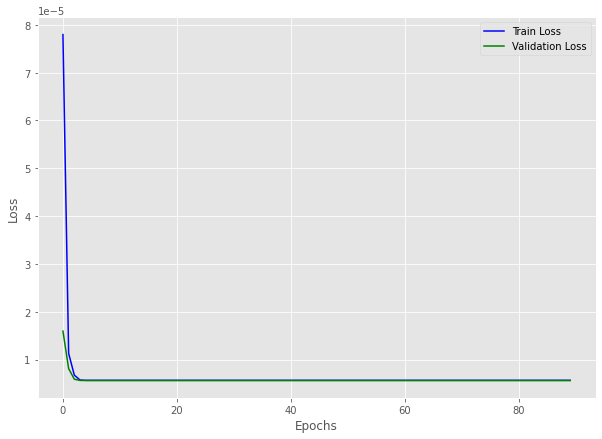

In [23]:
plt.figure(figsize=(10, 7))
plt.plot(Loss_recon, color='blue', label='Train Loss')
plt.plot(Loss_valid, color='green', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/My Drive/loss.png')
plt.show()

In [24]:
torch.save(model.state_dict(), '/content/drive/My Drive/GaussModel.pth')

In [ ]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#model = model()
#model.load_state_dict(torch.load('/content/drive/My Drive/GaussModel.pth', map_location=device))

<All keys matched successfully>

In [25]:
import torch
import cv2

import numpy as np
import glob as glob
import os
from torchvision.utils import save_image

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
i#mport sys
#sys.path.insert(0,'/content/drive/My Drive/model.pth/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
model = model.to(device)
model
#model=model.cpu()
#model.load_state_dict(torch.load('/content/drive/My Drive/model.pth'))

Anet(
  (conv1): Conv2d(1, 1, kernel_size=(33, 1), stride=(1, 1), padding=(16, 0), bias=False, padding_mode=replicate)
  (conv2): Conv2d(1, 1, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16), bias=False, padding_mode=replicate)
)

In [27]:
from google.colab.patches import cv2_imshow

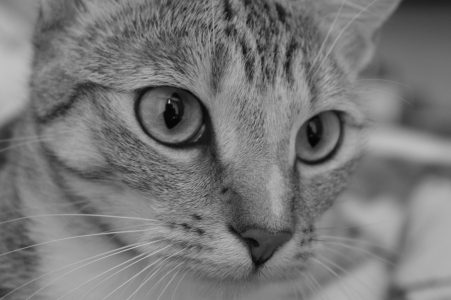

(300, 451, 1)


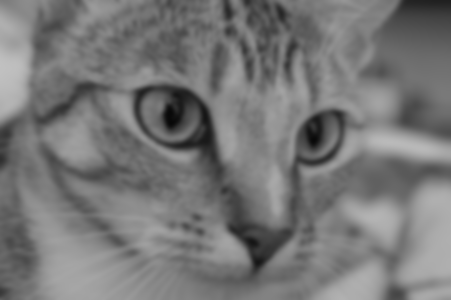

In [28]:

img_dirs = glob.glob('/content/drive/My Drive/test_chelsea/test_chelsea*')

for img_dir in img_dirs:
    img = cv2.imread(img_dir, cv2.IMREAD_COLOR)
    test_image_name = img_dir.split(os.path.sep)[-1].split('.')[0]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    cv2.imwrite(f"/content/drive/My Drive/catcake.png", img)
    img = img 
    cv2_imshow(img)
    cv2.waitKey(0)
    model.eval()
    with torch.no_grad():
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        img = torch.tensor(img, dtype=torch.float).to(device)
        img = img.unsqueeze(0)
        x2,_, _,_= model(img)
        recon = x2.cpu()
    save_image(recon, f"/content/drive/My Drive/MYcatcake.png")
    recon = recon.detach().numpy()
    recon = recon.reshape(recon.shape[2], recon.shape[3], recon.shape[1])
    print(recon.shape)
    cv2_imshow(recon)
    cv2.waitKey(0)

In [29]:
model.eval()
model.cpu
img.cpu
x2,_,U,V = model(img)

U=U.squeeze(1)
V=V.squeeze(0)
U.shape
U=U.cpu()
V=V.cpu()

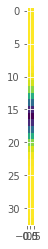

In [30]:
plt.imshow(U[0].detach().numpy())

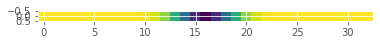

In [31]:
plt.imshow(V[0].detach().numpy())

In [32]:
U[0]

tensor([[-1.2384e-03],
        [-5.7589e-04],
        [-2.2270e-04],
        [-2.6594e-04],
        [-3.2202e-04],
        [-2.2720e-04],
        [-2.0819e-04],
        [-1.8932e-04],
        [-2.0794e-04],
        [-8.1610e-04],
        [-3.8387e-03],
        [-1.2594e-02],
        [-3.3071e-02],
        [-7.0141e-02],
        [-1.2012e-01],
        [-1.6517e-01],
        [-1.8706e-01],
        [-1.6423e-01],
        [-1.2012e-01],
        [-7.0565e-02],
        [-3.3483e-02],
        [-1.2864e-02],
        [-3.6727e-03],
        [-6.4483e-04],
        [-3.9371e-05],
        [ 7.7964e-05],
        [ 2.0170e-04],
        [-5.8677e-06],
        [-2.4825e-04],
        [-2.9366e-04],
        [-2.1904e-04],
        [-4.0615e-04],
        [-8.8227e-04]])

In [33]:
V[0]

tensor([[-8.5779e-04, -1.1277e-04,  2.6759e-05, -3.5721e-05, -7.1448e-05,
         -2.4844e-05, -1.6938e-04, -1.8369e-04, -1.1383e-04, -6.7870e-04,
         -3.4205e-03, -1.1945e-02, -3.2403e-02, -6.9744e-02, -1.2004e-01,
         -1.6515e-01, -1.8778e-01, -1.6479e-01, -1.1976e-01, -6.9661e-02,
         -3.2567e-02, -1.2005e-02, -3.2929e-03, -6.3043e-04, -2.1126e-04,
         -1.1017e-04,  8.6423e-05, -8.2229e-06, -1.3227e-04, -4.1627e-05,
         -4.8888e-05, -2.6859e-04, -9.2382e-04]])

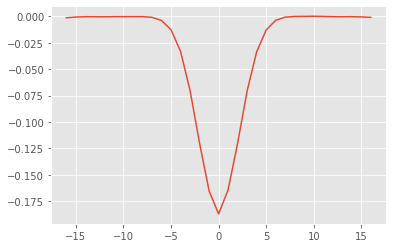

In [34]:
range = np.linspace(-int(33/2),int(33/2),33)
plt.plot(range , U[0])

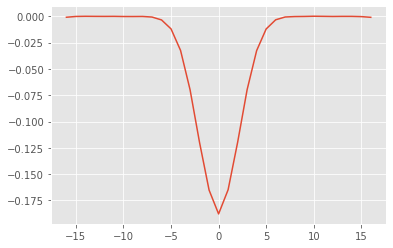

In [35]:
rangeV = np.linspace(-int(33/2),int(33/2),33)
plt.plot(rangeV , V[0].T)

In [36]:
UV = np.outer(U[0], V[0])
UV.shape

(33, 33)

In [37]:
UV

array([[ 1.0622772e-06,  1.3965892e-07, -3.3137766e-08, ...,
         6.0542796e-08,  3.3261733e-07,  1.1440520e-06],
       [ 4.9399347e-07,  6.4945951e-08, -1.5410141e-08, ...,
         2.8154370e-08,  1.5467788e-07,  5.3202143e-07],
       [ 1.9102941e-07,  2.5114879e-08, -5.9591678e-09, ...,
         1.0887416e-08,  5.9814610e-08,  2.0573499e-07],
       ...,
       [ 1.8788651e-07,  2.4701677e-08, -5.8611249e-09, ...,
         1.0708292e-08,  5.8830508e-08,  2.0235014e-07],
       [ 3.4839090e-07,  4.5803390e-08, -1.0868064e-08, ...,
         1.9855984e-08,  1.0908720e-07,  3.7521025e-07],
       [ 7.5679924e-07,  9.9497349e-08, -2.3608372e-08, ...,
         4.3132562e-08,  2.3696690e-07,  8.1505812e-07]], dtype=float32)

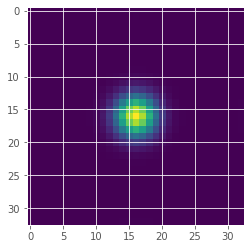

In [38]:
plt.imshow(UV)

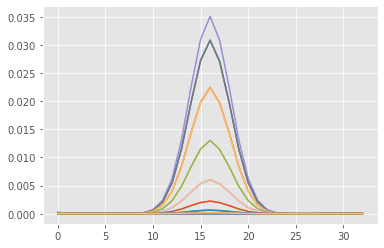

In [39]:
plt.plot(UV)